# Heart Failure Prediction

In this exercise, you will train a neural network on the [
Heart failure clinical records Data Set](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records) to predict if the patient will die or live in the followed-up period.

We are going to model this problem as a binary classification problem which detects whether the patient will live or die in the follow-up periodm, based on the other features.

This example is built using custom training, but we could've used the pre-made keras fucnctions for training like model.comple and model.fit. 

The core of custom training is using the model to calculate the logits on specific set of inputs and compute the loss(in this case **binary crossentropy**) by comparing the predicted outputs to the true outputs. We then update the trainable weights using the optimizer algorithm chosen. The optimizer algorithm requires our computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

We use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')

## Load and Preprocess the Dataset

We first download the dataset and create a data frame using pandas. We explicitly specify the column names because the CSV file does not have column headers.


Here we faced an error in loading the data. make sure to right click on the target file and copy the path, but not copy it fron the url field. 

In [34]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
data_file = tf.keras.utils.get_file("heart_failure_clinical_records_dataset.csv", DATASET_URL)

#Some csv files dont have coulumn name thus we have to add the names manually as the following:
#col_names = ["name1", "name2", "name3"]
#df = pd.read_csv(data_file, names=col_names, header=None)

16384/12239 [========================================] - 0s 0us/step


In [35]:
df= pd.read_csv(data_file)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


###Attribute Information:

Thirteen (13) clinical features:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient deceased during the follow-up period (boolean)

In case we incounter some attributes that we dont need like the name of the patient or his id, then id that case we have to do some preprocessing on the data by poping up the data using the following line.

In [ ]:
#df.pop("un_necessary_data")

Also, in case we noticed some character that is not integer we have to convert it using the following code lines.





In [ ]:
# df = df[df["coulumn_name_ where_the_char_ appears"] != 'char' ]
# df.coulumn_name_ where_the_char_ appears = pd.to_numeric(df.coulumn_name_ where_the_char_ appears)

We check the DEATH_EVENT distribution of the data. You can see that there are two classes, 0.0  and 1.0
According to the dataset:
* **0.0 = The patient did not decease during the follow-up period**
* **1.0 =  The patient deceased during the follow-up period**


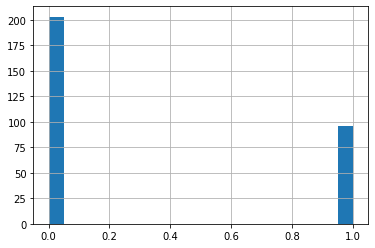

In [36]:
df['DEATH_EVENT'].hist(bins=20) 

In case we have two values that are not binary we can convert them using np.where.


numpy.where(condition[, x, y])

Where True, yield x, otherwise yield y

In [ ]:
#df['output_class'] = np.where(df['output_class'] == one_of_the_two_values, 0, 1)

We then split the dataset into training and testing sets. Since the number of samples is small, we will perform validation on the test set.

In [37]:
train, test = train_test_split(df, test_size = 0.2)

We get the statistics for training. We can look at statistics to get an idea about the distribution of plots. We will also be using the mean and standard deviation from statistics for normalizing the data

In [ ]:
train_stats.pop('DEATH_EVENT')
train_stats = train_stats.transpose()# so we can use it as an output
train_stats = train.describe()

We pop the class column from the training and test sets to create train and test outputs.

In [40]:
train_Y = train.pop("DEATH_EVENT")
test_Y = test.pop("DEATH_EVENT")

Here we normalize the data by using the formula: **X = (X - mean(X)) / StandardDeviation(X)**

$$x_{norm} = \frac{x - \mu}{\sigma}$$

In [41]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [42]:
norm_train_X = norm(train)
norm_test_X = norm(test)

We now create Tensorflow datasets for training and test sets to easily be able to build and manage an input pipeline for our model.

In [43]:
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

We shuffle and prepare a batched dataset to be used for training in our custom training loop.

In [44]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

test_dataset =  test_dataset.batch(batch_size=batch_size)

In [45]:
a = enumerate(train_dataset)

print(len(list(a)))

8


## Define the Model

Now we will define the model. Here, we use the Keras Functional API to create a simple network of two `Dense` layers. We have modelled the problem as a binary classification problem and hence we add a single layer with sigmoid activation as the final layer of the model.

In [46]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

## Define Optimizer and Loss

We use RMSprop optimizer and binary crossentropy as our loss function.

In [47]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

We also plot the confusion matrix to visualize the true outputs against the outputs predicted by the model.

In [49]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

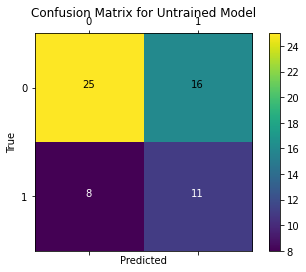

In [50]:
plot_confusion_matrix(test_Y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')

## Defining Metrics

### Defining Custom F1Score Metric
In this example, we will define a custom F1Score metric using the formula. 

**F1 Score = 2 * ((precision * recall) / (precision + recall))**

**precision = true_positives / (true_positives + false_positives)**

**recall = true_positives / (true_positives + false_negatives)**

We use `confusion_matrix` defined in `tf.math` to calculate precision and recall.

Here we have subclassed `tf.keras.Metric` and implemented the three required methods `update_state`, `result` and `reset_states`.


In [52]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        '''initializes attributes of the class'''
        
        # call the parent class init
        super(F1Score, self).__init__(name=name, **kwargs)

        # Initialize Required variables
        # true positives
        self.tp = tf.Variable(0, dtype = 'int32')
        # false positives
        self.fp = tf.Variable(0, dtype = 'int32')
        # true negatives
        self.tn = tf.Variable(0, dtype = 'int32')
        # false negatives
        self.fn = tf.Variable(0, dtype = 'int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates statistics for the metric
        
        Args:
            y_true: target values from the test data
            y_pred: predicted values by the model
        '''

        # Calulcate confusion matrix.
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
        
        # Update values of true positives, true negatives, false positives and false negatives from confusion matrix.
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])

    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)
      
        # Calculate recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)

        # Return F1 Score
        # F1 Score = 2 * ((precision * recall) / (precision + recall))
        f1_score =2 * ((precision * recall) / (precision + recall))
      
        
        return f1_score

    def reset_states(self):
        '''Resets all of the metric state variables.'''
        
        # The state of the metric will be reset at the start of each epoch.
        self.tp.assign(0)
        self.tn.assign(0) 
        self.fp.assign(0)
        self.fn.assign(0)


In [53]:
# Test Code:

test_F1Score = F1Score()

test_F1Score.tp = tf.Variable(2, dtype = 'int32')
test_F1Score.fp = tf.Variable(5, dtype = 'int32')
test_F1Score.tn = tf.Variable(7, dtype = 'int32')
test_F1Score.fn = tf.Variable(9, dtype = 'int32')
test_F1Score.result()


<tf.Tensor: shape=(), dtype=float64, numpy=0.2222222222222222>

We initialize the seprate metrics required for training and validation. In addition to our custom F1Score metric, we are also using `BinaryAccuracy` defined in `tf.keras.metrics`

In [54]:
train_f1score_metric = F1Score()
val_f1score_metric = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

## Applying Gradients

The core of training is using the model to calculate the logits on specific set of inputs and compute the loss(in this case **binary crossentropy**) by comparing the predicted outputs to the true outputs. We then update the trainable weights using the optimizer algorithm chosen. The optimizer algorithm requires our computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

We use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.


In [55]:
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    applies the gradients to the trainable model weights
    
    Args:
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        x: input data to the model
        y: target values for each input
    '''
    
    with tf.GradientTape() as tape:
  
        logits = model(x)
        loss_value = loss_object(y_true=y, y_pred=logits)
  
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
   
  
    return logits, loss_value

## Training Loop

This function performs training during one epoch. We run through all batches of training data in each epoch to make updates to trainable weights using our previous function.
We also call `update_state` on our metrics to accumulate the value of our metrics. 

We are displaying a progress bar to indicate completion of training in each epoch. Here we use `tqdm` for displaying the progress bar. 


In [57]:
def train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, 
                             train_acc_metric, train_f1score_metric, verbose=True):
    '''
    Computes the loss then updates the weights and metrics for one epoch.
    
    Args:
        train_dataset: the training dataset
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        train_acc_metric: calculates how often predictions match labels
        train_f1score_metric: custom metric we defined earlier
    '''
    losses = []

    #Iterate through all batches of training data
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        #Calculate loss and update trainable variables using optimizer
       
        logits, loss_value = apply_gradient(optimizer,loss_object, model, x_batch_train, y_batch_train)
        losses.append(loss_value)
       #

        #Round off logits to nearest integer and cast to integer for calulating metrics
        logits = tf.round(logits)
        logits = tf.cast(logits, 'int64')

        #Update the training metrics
      
        train_acc_metric.update_state(y_batch_train, logits)
        train_f1score_metric.update_state(y_batch_train, logits)
       

        #Update progress
        if verbose:
            print("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
    
    return losses

At the end of each epoch, we have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [58]:
def perform_validation():
    losses = []

    #Iterate through all batches of validation data.
    for x_val, y_val in test_dataset:

        #Calculate validation loss for current batch.
        val_logits = model(x_val) 
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)

        #Round off and cast outputs to either  or 1
        val_logits = tf.cast(tf.round(model(x_val)), 'int64')

        #Update validation metrics
        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)
        
    return losses

Next we define the training loop that runs through the training samples repeatedly over a fixed number of epochs. Here we combine the functions we built earlier to establish the following flow:
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

**Note** : We also calculate the training and validation losses for the whole epoch at the end of the epoch.

In [59]:
# Iterate over epochs.
epochs = 5
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    #Perform Training over all batches of train data
    losses_train = train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, train_acc_metric, train_f1score_metric)

    # Get results from training metrics
    train_acc = train_acc_metric.result()
    train_f1score = train_f1score_metric.result()

    #Perform validation on all batches of test data
    losses_val = perform_validation()

    # Get results from validation metrics
    val_acc = val_acc_metric.result()
    val_f1score = val_f1score_metric.result()

    #Calculate training and validation losses for current epoch
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epcoh %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc), train_f1score, val_f1score))

    #Reset states of all metrics
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    val_f1score_metric.reset_states()
    train_f1score_metric.reset_states()

Start of epoch 0
Training loss for step 0: 0.6538
Training loss for step 1: 0.6557
Training loss for step 2: 0.6868
Training loss for step 3: 0.6159
Training loss for step 4: 0.5693
Training loss for step 5: 0.5441
Training loss for step 6: 0.5645
Training loss for step 7: 0.5088

 Epcoh 0: Train loss: 0.5999  Validation Loss: 0.5608, Train Accuracy: 0.7211, Validation Accuracy 0.7366, Train F1 Score: 0.4426, Validation F1 Score: 0.4286
Start of epoch 1
Training loss for step 0: 0.4658
Training loss for step 1: 0.4418
Training loss for step 2: 0.5195
Training loss for step 3: 0.5857
Training loss for step 4: 0.4629
Training loss for step 5: 0.4764
Training loss for step 6: 0.5009
Training loss for step 7: 0.5653

 Epcoh 1: Train loss: 0.5023  Validation Loss: 0.5144, Train Accuracy: 0.7987, Validation Accuracy 0.8304, Train F1 Score: 0.6116, Validation F1 Score: 0.7059
Start of epoch 2
Training loss for step 0: 0.4860
Training loss for step 1: 0.4709
Training loss for step 2: 0.4054
Tr

## Evaluate the Model

### Plots for Evaluation

We plot the progress of loss as training proceeds over number of epochs.

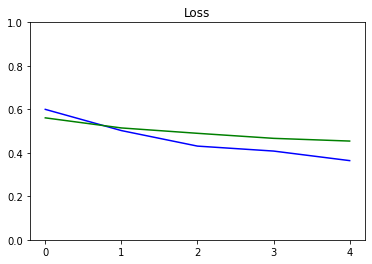

In [60]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

We plot the confusion matrix to visualize the true values against the values predicted by the model.

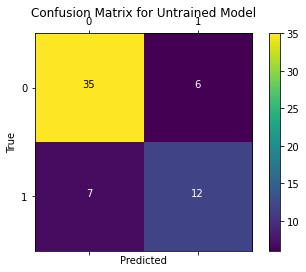

In [61]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_Y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')